# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [16]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

import re

In [17]:
df = pd.read_csv('/datasets/Churn.csv')
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


Признаки
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак
- Exited — факт ухода клиента

Не все признаки, нам понадобятся для обучения модели, признаки RowNumber, CustomerId, Surname можно исключить. 

In [18]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           9091 non-null   float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


Переименуем столбцы

In [19]:
for name in df.columns:
    rena = re.sub(r"(?=[A-Z])(?!^)", '_', name).lower()
    df = df.rename(columns={name:rena})
df = df.rename(columns={"geography":"country"})

In [20]:
df.columns

Index(['credit_score', 'country', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object')

In [21]:
df.exited.mean()

0.2037

Классы не сбалансированы, "1" те кто ушли составляют 20%, всех клиентов в выборке

In [22]:
df.tenure.isna().mean()

0.0909

В столбце 'tenure' содержатся пропуски и составляют 9%, заполним их медианными значениями. 

Text(0.5, 0, 'Возраст клиента')

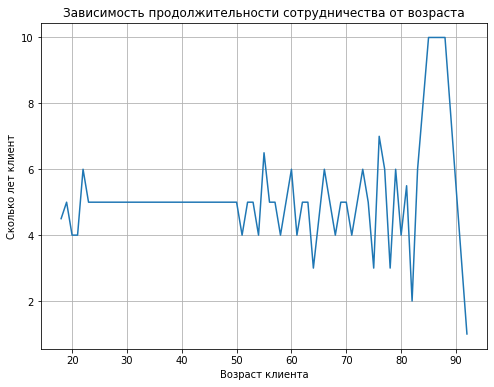

In [23]:
ax = df.groupby('age')['tenure'].median().plot(figsize = (8,6), grid =True)
ax.set_title('Зависимость продолжительности сотрудничества от возраста')
ax.set_ylabel('Сколько лет клиент')
ax.set_xlabel('Возраст клиента') 

In [24]:
print(df[df.age < 50].tenure.median(), 'медиана для людей младше 50')
print(df[df.age >= 50].tenure.median(), 'медиана для людей старше 50')

5.0 медиана для людей младше 50
5.0 медиана для людей старше 50


Медиана равна 5. Заполним пропуски этим значением и сразу приведем к целочисленному типу

In [25]:
df.tenure = df.tenure.fillna(5).astype(int)
print(df.tenure.dtype)
print(df.tenure.isna().sum())

int64
0


Переименуем столбцы

Проведём кодирование данных методом OHE.

In [26]:
df_ohe = pd.get_dummies(df, drop_first = True)

## Исследование задачи

### Препроцессинг

In [27]:
target = df_ohe.exited
features = df_ohe.drop(['exited'], axis = 1)

Так как данные для теста не предоставляются, разобьём исходную выборку на: обучающую, валидационную и тестовую, в отношении 60/20/20 соотвественно.

In [28]:
features_train, features_vt, target_train, target_vt = train_test_split(features, target, test_size = 0.4, random_state = 123, stratify = target)
features_valid, features_test, target_valid, target_test = train_test_split(features_vt, target_vt, test_size = 0.5, random_state = 123, stratify = target_vt)

In [29]:
print(features_train.shape,
features_valid.shape,
features_test.shape)

(6000, 11) (2000, 11) (2000, 11)


Проведём масштабирование выборок

In [30]:
numeric = ['credit_score', 'age', 'tenure', 'balance',
       'num_of_products', 'estimated_salary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

/tmp/ipykernel_37/1572206702.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_37/1572206702.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

### Подбор модели, без учёта дисбаланса классов

Подберем наилучшие параметры для Random Forest 

In [31]:
def choose_forest(features_train, target_train, features_valid, target_valid):
    best_model = None
    f1 = 0
    for n in range(30,100,3):
        for j in range(2,15):
            model = RandomForestClassifier(n_estimators = n, max_depth = j, random_state = 12345)
            model.fit(features_train,target_train)
            predictions_valid = model.predict(features_valid)
            f1_new = f1_score(target_valid,predictions_valid)
            if f1_new > f1:
                f1 = f1_new
                best_model = model
    print ('n_estimators = ', n)
    print ('max_depth = ', j)
    print ('f1 = ', f1)
    return model

In [32]:
choose_forest(features_train, target_train, features_valid, target_valid)

n_estimators =  99
max_depth =  14
f1 =  0.5709828393135725


RandomForestClassifier(max_depth=14, n_estimators=99, random_state=12345)

In [33]:
model = LogisticRegression(random_state = 12345,solver='liblinear')
model.fit(features_train,target_train)
predictions_valid = model.predict(features_valid)
print ('f1 = ', f1_score(target_valid,predictions_valid))

f1 =  0.29840142095914746


**Выводы:** модель  Random Forest дала результат лучше, чем Линейная регрессия, при дисбалансе классов f1 = 0.57.

## Борьба с дисбалансом

### Использование балансировки класса в параметрах модели

Обучим модель Логистическая Регрессия с параметром class_weight = 'balanced'

In [34]:
model = LogisticRegression(random_state=12345, solver='liblinear',class_weight = 'balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("f1 = ", f1_score(target_valid, predicted_valid))

f1 =  0.46140350877192987


In [35]:
model = RandomForestClassifier(n_estimators = 99, max_depth = 14, random_state = 12345, class_weight = 'balanced')
model.fit(features_train,target_train)
predictions_valid = model.predict(features_valid)
print(f1_score(target_valid,predictions_valid))

0.5793304221251819


### Увеличим обучающую выборку, способом upsample

In [36]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

model = LogisticRegression(random_state=12345,solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("f1 = ", f1_score(target_valid, predicted_valid))

f1 =  0.4575389948006932


In [37]:
best_model = choose_forest(features_upsampled, target_upsampled, features_valid, target_valid)

n_estimators =  99
max_depth =  14
f1 =  0.6234357224118315


### Уменьшим обучающую выборку, способом downsample

In [38]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.2)

In [39]:
model = LogisticRegression(random_state=12345,solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

# < напишите код здесь >

print("f1 = ", f1_score(target_valid, predicted_valid))

f1 =  0.453639846743295


In [40]:
choose_forest(features_downsampled, target_downsampled, features_valid, target_valid)

n_estimators =  99
max_depth =  14
f1 =  0.5539000876424189


RandomForestClassifier(max_depth=14, n_estimators=99, random_state=12345)

**Вывод:** увеличение выборки лучше помогло справиться с дисбалансом классов, наилучшей результат показала модель Random Forest, с теми же гиперпараметрами, что и для несбалансированной выборки. Количество деревьев = 99, максимальная глубина равна 14. f1 стало 0.62

## Тестирование модели

Тестирование наилучшей модели, "Случайный лес" с количеством деревьев 99, максимальной глубиной дерева 14.

In [41]:
predicted_test = best_model.predict(features_test)
print("f1 = ", f1_score(target_test, predicted_test))

f1 =  0.6248462484624846


roc_auc 0.8603002077578348


Text(0.5, 1.0, 'ROC-кривая')

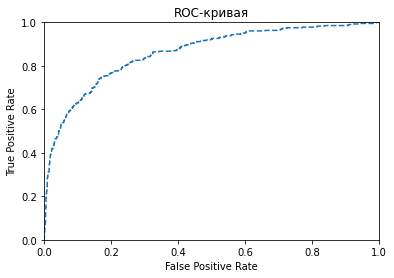

In [42]:
probabilities_test = best_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 
print('roc_auc', roc_auc_score(target_test, probabilities_one_test))

plt.figure()


# ROC-кривая случайной модели (выглядит как прямая)
plt.plot(fpr,tpr, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

Подобранная модель, даёт результаты лучше, чем случайная.

In [44]:
dummy_model = DummyClassifier(strategy='most_frequent').fit(features_train,target_train)
dummy_predictions = dummy_model.predict(features_test)

print('f1 score dummy: ', f1_score(target_test,dummy_predictions))

f1 score dummy:  0.0


**Выводы:** На тестовых данных выбранная модель RandomForestClassifier(max_depth=14, n_estimators=99) дала оценку f1 даже лучше чем на валидационной выборке f1 = 0.624. 
Таким образом для улучшения обучения при дисбалансе классов, помогло увеличение выборки upsampling. 
В свою очередь, константная модель показала очень плохой показатель, f1 = 0